In [1]:
import visual_behavior_glm.src.GLM_params as glm_params
import visual_behavior_glm.src.GLM_analysis_tools as gat
from visual_behavior_glm.src.glm import GLM
import matplotlib.pyplot as plt
import visual_behavior.data_access.loading as loading
import visual_behavior.database as db
import plotly.express as px

import pandas as pd
import numpy as np
import os

import seaborn as sns

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_api/behavior_ophys_nwb_api.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%matplotlib notebook
%widescreen

In [3]:
results_all = gat.retrieve_results(results_type='full')

In [4]:
rs = gat.retrieve_results(search_dict = {'glm_version': '4_L2_optimize_by_cell'}, results_type='summary')
rs

_id  index           dropout  \
0        5f22221a7eeb3a3cbb69c983      0              Full   
1        5f22221a7eeb3a3cbb69c984      1         intercept   
2        5f22221a7eeb3a3cbb69c985      2              time   
3        5f22221a7eeb3a3cbb69c986      3         pre_licks   
4        5f22221a7eeb3a3cbb69c987      4        post_licks   
...                           ...    ...               ...   
1365755  5f24621b2ac3d684bf7369e9     27  model_omissions1   
1365756  5f24621b2ac3d684bf7369ea     28    model_timing1D   
1365757  5f24621b2ac3d684bf7369eb     29        all-images   
1365758  5f24621b2ac3d684bf7369ec     30            visual   
1365759  5f24621b2ac3d684bf7369ed     31         beh_model   

         variance_explained  fraction_change_from_full  \
0                  0.229436                   0.000000   
1                  0.229937                   0.002183   
2                  0.229769                   0.001453   
3                  0.229634                   0.000864   
4                  0.227139                  -0.010010   
...                     ...                        ...   
1365755            0.048034                   0.048249   
1365756            0.048441                   0.057133   
1365757            0.039222                  -0.144061   
1365758            0.034920                  -0.237943   
1365759            0.057378                   0.252150   

         absolute_change_from_full  cell_specimen_id  ophys_experiment_id  \
0                         0.000000        1017215561            991852008   
1                         0.000501        1017215561            991852008   
2                         0.000333        1017215561            991852008   
3                         0.000198        1017215561            991852008   
4                        -0.002297        1017215561            991852008   
...                            ...               ...                  ...   
1365755                   0.002211         962642740            808621034   
1365756                   0.002618         962642740            808621034   
1365757                  -0.006601         962642740            808621034   
1365758                  -0.010903         962642740            808621034   
1365759                   0.011554         962642740            808621034   

         ophys_session_id  behavior_session_id  container_id  \
0               991639544            991662910    1018028067   
1               991639544            991662910    1018028067   
2               991639544            991662910    1018028067   
3               991639544            991662910    1018028067   
4               991639544            991662910    1018028067   
...                   ...                  ...           ...   
1365755         808340530            808432167     803589437   
1365756         808340530            808432167     803589437   
1365757         808340530            808432167     803589437   
1365758         808340530            808432167     803589437   
1365759         808340530            808432167     803589437   

                     project_code container_workflow_state  \
0        VisualBehaviorMultiscope                  holding   
1        VisualBehaviorMultiscope                  holding   
2        VisualBehaviorMultiscope                  holding   
3        VisualBehaviorMultiscope                  holding   
4        VisualBehaviorMultiscope                  holding   
...                           ...                      ...   
1365755            VisualBehavior             container_qc   
1365756            VisualBehavior             container_qc   
1365757            VisualBehavior             container_qc   
1365758            VisualBehavior             container_qc   
1365759            VisualBehavior             container_qc   

        experiment_workflow_state               session_name  \
0                          passed   20191202_479839_6imagesB   
1                    

In [5]:
rs['identifier'] = rs['ophys_experiment_id'].astype(str) + '_' +  rs['cell_specimen_id'].astype(str)

In [6]:
cutoff = 0.01
cells_to_keep = rs.query('dropout == "Full" and variance_explained >= @cutoff')['identifier'].unique()

In [7]:
rsp = rs.query('identifier in @cells_to_keep').pivot(index='identifier',columns='dropout',values='fraction_change_from_full').reset_index()
rsp

dropout             identifier  Full  all-images  beh_model    change  \
0        1000743008_1003146172   0.0   -0.140223  -0.001848  0.000581   
1        1000743008_1003146180   0.0   -0.155019   0.004636  0.000530   
2        1000743008_1003146183   0.0   -0.210215   0.062499  0.000224   
3        1000743008_1003146186   0.0   -0.368535   0.021722  0.000232   
4        1000743008_1003146190   0.0   -0.089674   0.000823  0.000713   
...                        ...   ...         ...        ...       ...   
26790      995439942_994309997   0.0   -0.673633   0.086221  0.006062   
26791      995439942_994310000   0.0   -0.485011   0.007001  0.004174   
26792      995439942_994310003   0.0   -1.118526   0.042506  0.000775   
26793      995439942_994310018   0.0   -0.541743   0.006398  0.003886   
26794      995439942_994310024   0.0   -0.277435   0.013547  0.000625   

dropout  correct_rejects  false_alarms      hits    image0    image1  \
0               0.014875      0.008197  0.005280 -0.000634  0.003108   
1               0.020636      0.011811  0.003584  0.002961  0.003979   
2               0.002435      0.001871  0.001834  0.001881  0.002758   
3               0.002308      0.006869  0.002990 -0.001212 -0.003161   
4               0.027508      0.019429  0.006967  0.006088  0.004045   
...                  ...           ...       ...       ...       ...   
26790           0.071843      0.050225  0.058348 -0.005161  0.010604   
26791           0.067006      0.025908  0.024597  0.014368  0.014290   
26792           0.003791      0.001357  0.004339  0.000590 -0.000652   
26793           0.040050      0.036957  0.039209  0.019981 -0.008514   
26794           0.005525      0.004325  0.005053  0.000903  0.003351   

dropout    image2    image3    image4    image5    image6    image7  \
0        0.002692  0.001819  0.003621 -0.001186 -0.026248  0.002645   
1       -0.007203 -0.007210  0.002283 -0.018611  0.002152  0.002657   
2       -0.015761  0.000383  0.000302 -0.012279  0.008475  0.001058   
3        0.000206 -0.049498  0.001615 -0.021775  0.000046  0.002221   
4       -0.003198 -0.024926  0.003739  0.002454 -0.000550  0.008610   
...           ...       ...       ...       ...       ...       ...   
26790    0.016987  0.005398  0.010657  0.016359 -0.052912 -0.017866   
26791   -0.012931  0.007199  0.001583  0.006884 -0.065082  0.001343   
26792   -0.001458 -0.001410 -0.000970 -0.000321 -0.008589 -0.000520   
26793    0.007828  0.020179 -0.061918  0.016950  0.010580  0.016852   
26794   -0.001719  0.001421 -0.030594  0.001062  0.001363 -0.003418   

dropout  image_expectation  intercept    misses  model_bias  model_omissions1  \
0                 0.000947   0.000913 -0.001280   -0.001924          0.000501   
1                 0.000976   0.000081  0.006030    0.000728          0.001277   
2                -0.001232  -0.002156  0.000572    0.010619          0.029392   
3                -0.003134   0.003374  0.002284    0.014580          0.006673   
4                 0.001467   0.000038  0.000181   -0.000054          0.001188   
...                    ...        ...       ...         ...               ...   
26790             0.012319  -0.013133  0.032441   -0.187010         -0.042443   
26791             0.007638  -0.000912  0.030111    0.004711         -0.006249   
26792            -0.000430  -0.006349  0.001093    0.000506         -0.102949   
26793             0.011578  -0.000300  0.020430    0.004984         -0.013852   
26794            -0.000713  -0.001291  0.003148    0.004363          0.003764   

dropout  model_task0  model_timing1D  omissions  post_lick_bouts  post_licks  \
0          -0.000538        0.000135   0.008544         0.007587   -0.005937   
1           0.000856        0.002049   0.020436         0.001011    0.003103   
2          -0.001927        0.021750  -0.000316        -0.004966    0.002149   
3           0.005393       -0.001058   0.002760        -0.001018    0.000574   
4           0.000657       -0.00

In [189]:
rspm = rsp.merge(rs[['identifier','cre_line','cell_specimen_id','session_type','equipment_name']].drop_duplicates(),left_on='identifier',right_on='identifier',how='left')

def map_session_types(session_type):
    session_id = session_type[6:7]
    return session_id
rspm['session_id'] = rspm['session_type'].map(lambda st:map_session_types(st))

rspm

identifier  Full  all-images  beh_model    change  \
0      1000743008_1003146172   0.0   -0.140223  -0.001848  0.000581   
1      1000743008_1003146180   0.0   -0.155019   0.004636  0.000530   
2      1000743008_1003146183   0.0   -0.210215   0.062499  0.000224   
3      1000743008_1003146186   0.0   -0.368535   0.021722  0.000232   
4      1000743008_1003146190   0.0   -0.089674   0.000823  0.000713   
...                      ...   ...         ...        ...       ...   
26790    995439942_994309997   0.0   -0.673633   0.086221  0.006062   
26791    995439942_994310000   0.0   -0.485011   0.007001  0.004174   
26792    995439942_994310003   0.0   -1.118526   0.042506  0.000775   
26793    995439942_994310018   0.0   -0.541743   0.006398  0.003886   
26794    995439942_994310024   0.0   -0.277435   0.013547  0.000625   

       correct_rejects  false_alarms      hits    image0    image1    image2  \
0             0.014875      0.008197  0.005280 -0.000634  0.003108  0.002692   
1             0.020636      0.011811  0.003584  0.002961  0.003979 -0.007203   
2             0.002435      0.001871  0.001834  0.001881  0.002758 -0.015761   
3             0.002308      0.006869  0.002990 -0.001212 -0.003161  0.000206   
4             0.027508      0.019429  0.006967  0.006088  0.004045 -0.003198   
...                ...           ...       ...       ...       ...       ...   
26790         0.071843      0.050225  0.058348 -0.005161  0.010604  0.016987   
26791         0.067006      0.025908  0.024597  0.014368  0.014290 -0.012931   
26792         0.003791      0.001357  0.004339  0.000590 -0.000652 -0.001458   
26793         0.040050      0.036957  0.039209  0.019981 -0.008514  0.007828   
26794         0.005525      0.004325  0.005053  0.000903  0.003351 -0.001719   

         image3    image4    image5    image6    image7  image_expectation  \
0      0.001819  0.003621 -0.001186 -0.026248  0.002645           0.000947   
1     -0.007210  0.002283 -0.018611  0.002152  0.002657           0.000976   
2      0.000383  0.000302 -0.012279  0.008475  0.001058          -0.001232   
3     -0.049498  0.001615 -0.021775  0.000046  0.002221          -0.003134   
4     -0.024926  0.003739  0.002454 -0.000550  0.008610           0.001467   
...         ...       ...       ...       ...       ...                ...   
26790  0.005398  0.010657  0.016359 -0.052912 -0.017866           0.012319   
26791  0.007199  0.001583  0.006884 -0.065082  0.001343           0.007638   
26792 -0.001410 -0.000970 -0.000321 -0.008589 -0.000520          -0.000430   
26793  0.020179 -0.061918  0.016950  0.010580  0.016852           0.011578   
26794  0.001421 -0.030594  0.001062  0.001363 -0.003418          -0.000713   

       intercept    misses  model_bias  model_omissions1  model_task0  \
0       0.000913 -0.001280   -0.001924          0.000501    -0.000538   
1       0.000081  0.006030    0.000728          0.001277     0.000856   
2      -0.002156  0.000572    0.010619          0.029392    -0.001927   
3       0.003374  0.002284    0.014580          0.006673     0.005393   
4       0.000038  0.000181   -0.000054          0.001188     0.000657   
...          ...       ...         ...               ...          ...   
26790  -0.013133  0.032441   -0.187010         -0.042443     0.019241   
26791  -0.000912  0.030111    0.004711         -0.006249     0.001660   
26792  -0.006349  0.001093    0.000506         -0.102949    -0.001359   
26793  -0.000300  0.020430    0.004984         -0.013852    -0.001372   
26794  -0.001291  0.003148    0.004363          0.003764     0.001219   

       model_timing1D  omissions  post_lick_bouts  post_licks  pre_lick_bouts  \
0            0.000135   0.008544         0.007587   -0.005937        0.011424   
1            0.002049   0.020436         0.001011    0.003103        0.031004   
2            0.021750  -0.000316        -0.004966    0.002149        0.003036   
3           -0.001058   0.002760        -0.001018    0.000574     

In [178]:
rspm[rspm['all-images']<-1]

identifier  Full  all-images  beh_model    change  \
34     1003771249_1003146186   0.0   -1.117131   0.228350  0.001037   
51     1006270853_1004425319   0.0   -1.054709   0.177399  0.000355   
130      775614751_962635629   0.0   -1.086542  -0.003101  0.000747   
132      775614751_962635733   0.0   -1.214496   0.679233  0.004234   
133      775614751_962635753   0.0   -1.013768  -0.032277  0.000811   
...                      ...   ...         ...        ...       ...   
26501    994278291_993887630   0.0   -1.023946   0.039956  0.000262   
26614    994790553_993886927   0.0   -1.122255   0.059297  0.000455   
26640    994790553_993887080   0.0   -1.003814   0.124427  0.000350   
26779    995280513_994309940   0.0   -1.015309   0.487181  0.000185   
26792    995439942_994310003   0.0   -1.118526   0.042506  0.000775   

       correct_rejects  false_alarms      hits    image0    image1    image2  \
34        4.643189e-02      0.020956  0.072833  0.014867  0.009431 -0.026080   
51        1.258287e-02      0.012932  0.007859  0.001097 -0.000114  0.002910   
130      -2.157227e-11      0.003877  0.002747 -0.001219  0.005047  0.001384   
132       6.296528e-11      0.038063  0.009817  0.022702  0.014888  0.006892   
133       1.089199e-10      0.003329  0.001723  0.000046  0.002789  0.001926   
...                ...           ...       ...       ...       ...       ...   
26501     6.635730e-03      0.001591  0.003452 -0.000938 -0.000865 -0.004873   
26614     3.105960e-03      0.000935  0.004156  0.002287  0.003118 -0.004628   
26640     3.277683e-03      0.000126  0.001092 -0.041049 -0.000039  0.000134   
26779     1.511575e-02      0.011482  0.003000 -0.029420  0.001261  0.003003   
26792     3.790673e-03      0.001357  0.004339  0.000590 -0.000652 -0.001458   

         image3    image4    image5    image6    image7  image_expectation  \
34     0.017521  0.005914  0.014637 -0.023622 -0.172522           0.008039   
51     0.002991  0.000604 -0.033780 -0.001203  0.002579           0.000498   
130   -0.000511  0.001507  0.003063 -0.031100  0.000511          -0.001740   
132    0.028619 -0.042287  0.025317  0.009160  0.003427          -0.015324   
133    0.000842  0.002765 -0.046841  0.001877  0.003501           0.001764   
...         ...       ...       ...       ...       ...                ...   
26501  0.000431 -0.001304 -0.000163 -0.062473 -0.003788          -0.000487   
26614  0.004144  0.002305  0.006357 -0.068547 -0.001011           0.004050   
26640 -0.000051  0.000206 -0.000014  0.000105  0.000135          -0.000848   
26779 -0.000497  0.001887 -0.002385 -0.009150 -0.000009          -0.004937   
26792 -0.001410 -0.000970 -0.000321 -0.008589 -0.000520          -0.000430   

       intercept    misses  model_bias  model_omissions1  model_task0  \
34      0.001892  0.024555   -0.009576         -0.044403     0.072844   
51      0.024195  0.010783    0.009957          0.078128     0.039462   
130    -0.027791  0.002837    0.005468         -0.043991    -0.031063   
132     0.095613  0.029483    0.088413          0.073516     0.387054   
133    -0.000159  0.003174   -0.000921         -0.068274     0.000457   
...          ...       ...         ...               ...          ...   
26501   0.004758  0.006357    0.022683          0.012367     0.019811   
26614   0.006959  0.002083   -0.001452          0.039480     0.017618   
26640  -0.000668 -0.000934    0.035617          0.027637     0.004845   
26779   0.000963  0.011217    0.033621         -0.044837    -0.030500   
26792  -0.006349  0.001093    0.000506         -0.102949    -0.001359   

       model_timing1D  omissions  post_lick_bouts  post_licks  pre_lick_bouts  \
34           0.061393   0.101273         0.013356    0.030673        0.079064   
51           0.090678  -0.112853         0.008631    0.008843       -0.000145   
130          0.020397   0.015018        -0.000100   -0.009525        0.009640   
132          0.184838   0.088140         0.026707    0.008339     

In [185]:
dropouts_to_show = ['Full','all-images']
rs.query('identifier == "1006270853_1004425319" and dropout in @dropouts_to_show')[['specimen_id','cre_line','dropout','variance_explained','fraction_change_from_full']]

specimen_id      cre_line     dropout  variance_explained  \
613536    967938399  Vip-IRES-Cre        Full            0.038675   
613565    967938399  Vip-IRES-Cre  all-images           -0.002116   

        fraction_change_from_full  
613536                   0.000000  
613565                  -1.054709

In [9]:
cols_for_clustering = [col for col in rspm.columns if col not in ['visual','identifier','cre_line','session_type','equipment_name', 'session_id']]
cols_for_clustering

['Full',
 'all-images',
 'beh_model',
 'change',
 'correct_rejects',
 'false_alarms',
 'hits',
 'image0',
 'image1',
 'image2',
 'image3',
 'image4',
 'image5',
 'image6',
 'image7',
 'image_expectation',
 'intercept',
 'misses',
 'model_bias',
 'model_omissions1',
 'model_task0',
 'model_timing1D',
 'omissions',
 'post_lick_bouts',
 'post_licks',
 'pre_lick_bouts',
 'pre_licks',
 'pupil',
 'rewards',
 'running',
 'time']

In [10]:
sorted_cols = rspm[cols_for_clustering].median(axis=0).sort_values().index

In [12]:
rspm.set_index('identifier')[sorted_cols].sort_values(by=['all-images','running'])

all-images   running     pupil  Full    image4  \
identifier                                                             
846487947_961985164   -13.206204  1.216737 -0.480915   0.0 -0.041766   
822647135_962554101   -10.171026  0.101770 -0.003982   0.0  0.026690   
848694639_962574986    -9.040117 -0.014500 -3.010270   0.0 -0.004812   
974384470_1007092516   -8.912741 -0.452497  0.261638   0.0  0.033379   
826585773_961885003    -8.606362  0.084364 -0.153492   0.0 -0.353953   
...                          ...       ...       ...   ...       ...   
844395446_961985428     1.637859 -0.266629 -3.165451   0.0 -0.013241   
826585773_961880837     1.664575 -0.120754 -0.374723   0.0  0.082283   
993862120_993614239     1.720064 -0.070957 -3.296149   0.0  0.064734   
795076128_962594029     1.823503  0.071054  0.018576   0.0 -0.001210   
945586425_1028835794    2.189148  0.681069 -4.206540   0.0  0.025518   

                        change    image7    image0    image5  post_licks  \
identifier                                                                 
846487947_961985164   0.042602  0.040312  0.018240 -0.329811    0.067418   
822647135_962554101   0.000789  0.049128  0.041075  0.061628    0.050831   
848694639_962574986   0.003548  0.059354  0.053438 -0.050740    0.015879   
974384470_1007092516  0.000678  0.000846 -0.152486  0.034992    0.003034   
826585773_961885003   0.002084 -0.018688 -0.001197  0.050314    0.149187   
...                        ...       ...       ...       ...         ...   
844395446_961985428   0.009575 -0.004494  0.212116  0.006470    0.083023   
826585773_961880837  -0.009050  0.039196 -0.002985  0.096527    0.037259   
993862120_993614239   0.000417  0.090325  0.042638  0.106502    0.156520   
795076128_962594029   0.002441  0.012220  0.014616  0.009131    0.009329   
945586425_1028835794  0.023298 -0.034239 -0.009970  0.080015    0.022303   

                        image3  intercept    image6    image1    image2  \
identifier                                                                
846487947_961985164   0.076178  -0.018807  0.023480  0.043971  0.063961   
822647135_962554101   0.040118   0.036485  0.024198  0.037167 -0.105839   
848694639_962574986  -0.175339   1.006192  0.017608  0.037880 -0.043053   
974384470_1007092516  0.088963   0.002936  0.023562  0.001872  0.047357   
826585773_961885003   0.048022  -0.090127  0.097819  0.034801  0.103586   
...                        ...        ...       ...       ...       ...   
844395446_961985428   0.001690   0.030882 -0.018426  0.054293  0.015282   
826585773_961880837  -0.023575  -0.416039  0.140778 -0.015625  0.042823   
993862120_993614239   0.161103   0.209259  0.052941  0.048951  0.094885   
795076128_962594029   0.222737   0.037742  0.001493  0.014135  0.023411   
945586425_1028835794  0.022597  -0.554172 -0.005518  0.012773  0.083912   

                          time  image_expectation  post_lick_bouts  \
identifier                                                           
846487947_961985164   0.429513           0.018810         0.041542   
822647135_962554101  -0.611550           0.019462         0.001391   
848694639_962574986   1.647520           0.046154         0.035147   
974384470_1007092516  0.197254           0.016605         0.000395   
826585773_961885003   1.740260           0.031522         0.032812   
...                        ...                ...              ...   
844395446_961985428  -1.151339           0.006490        -0.071944   
826585773_961880837   2.678429           0.067688         0.023722   
993862120_993614239   0.635113           0.176457         0.054434   
795076128_962594029  -0.155544           0.008414         0.023552   
945586425_1028835794 -0.170109           0.046613         0.013294   

                      model_omissions1  model_task0  model_timing1D  \
identifier                                                            
846487947_961985164          -0.906916     0.841591        1.209437

<IPython.core.display.Javascript object>


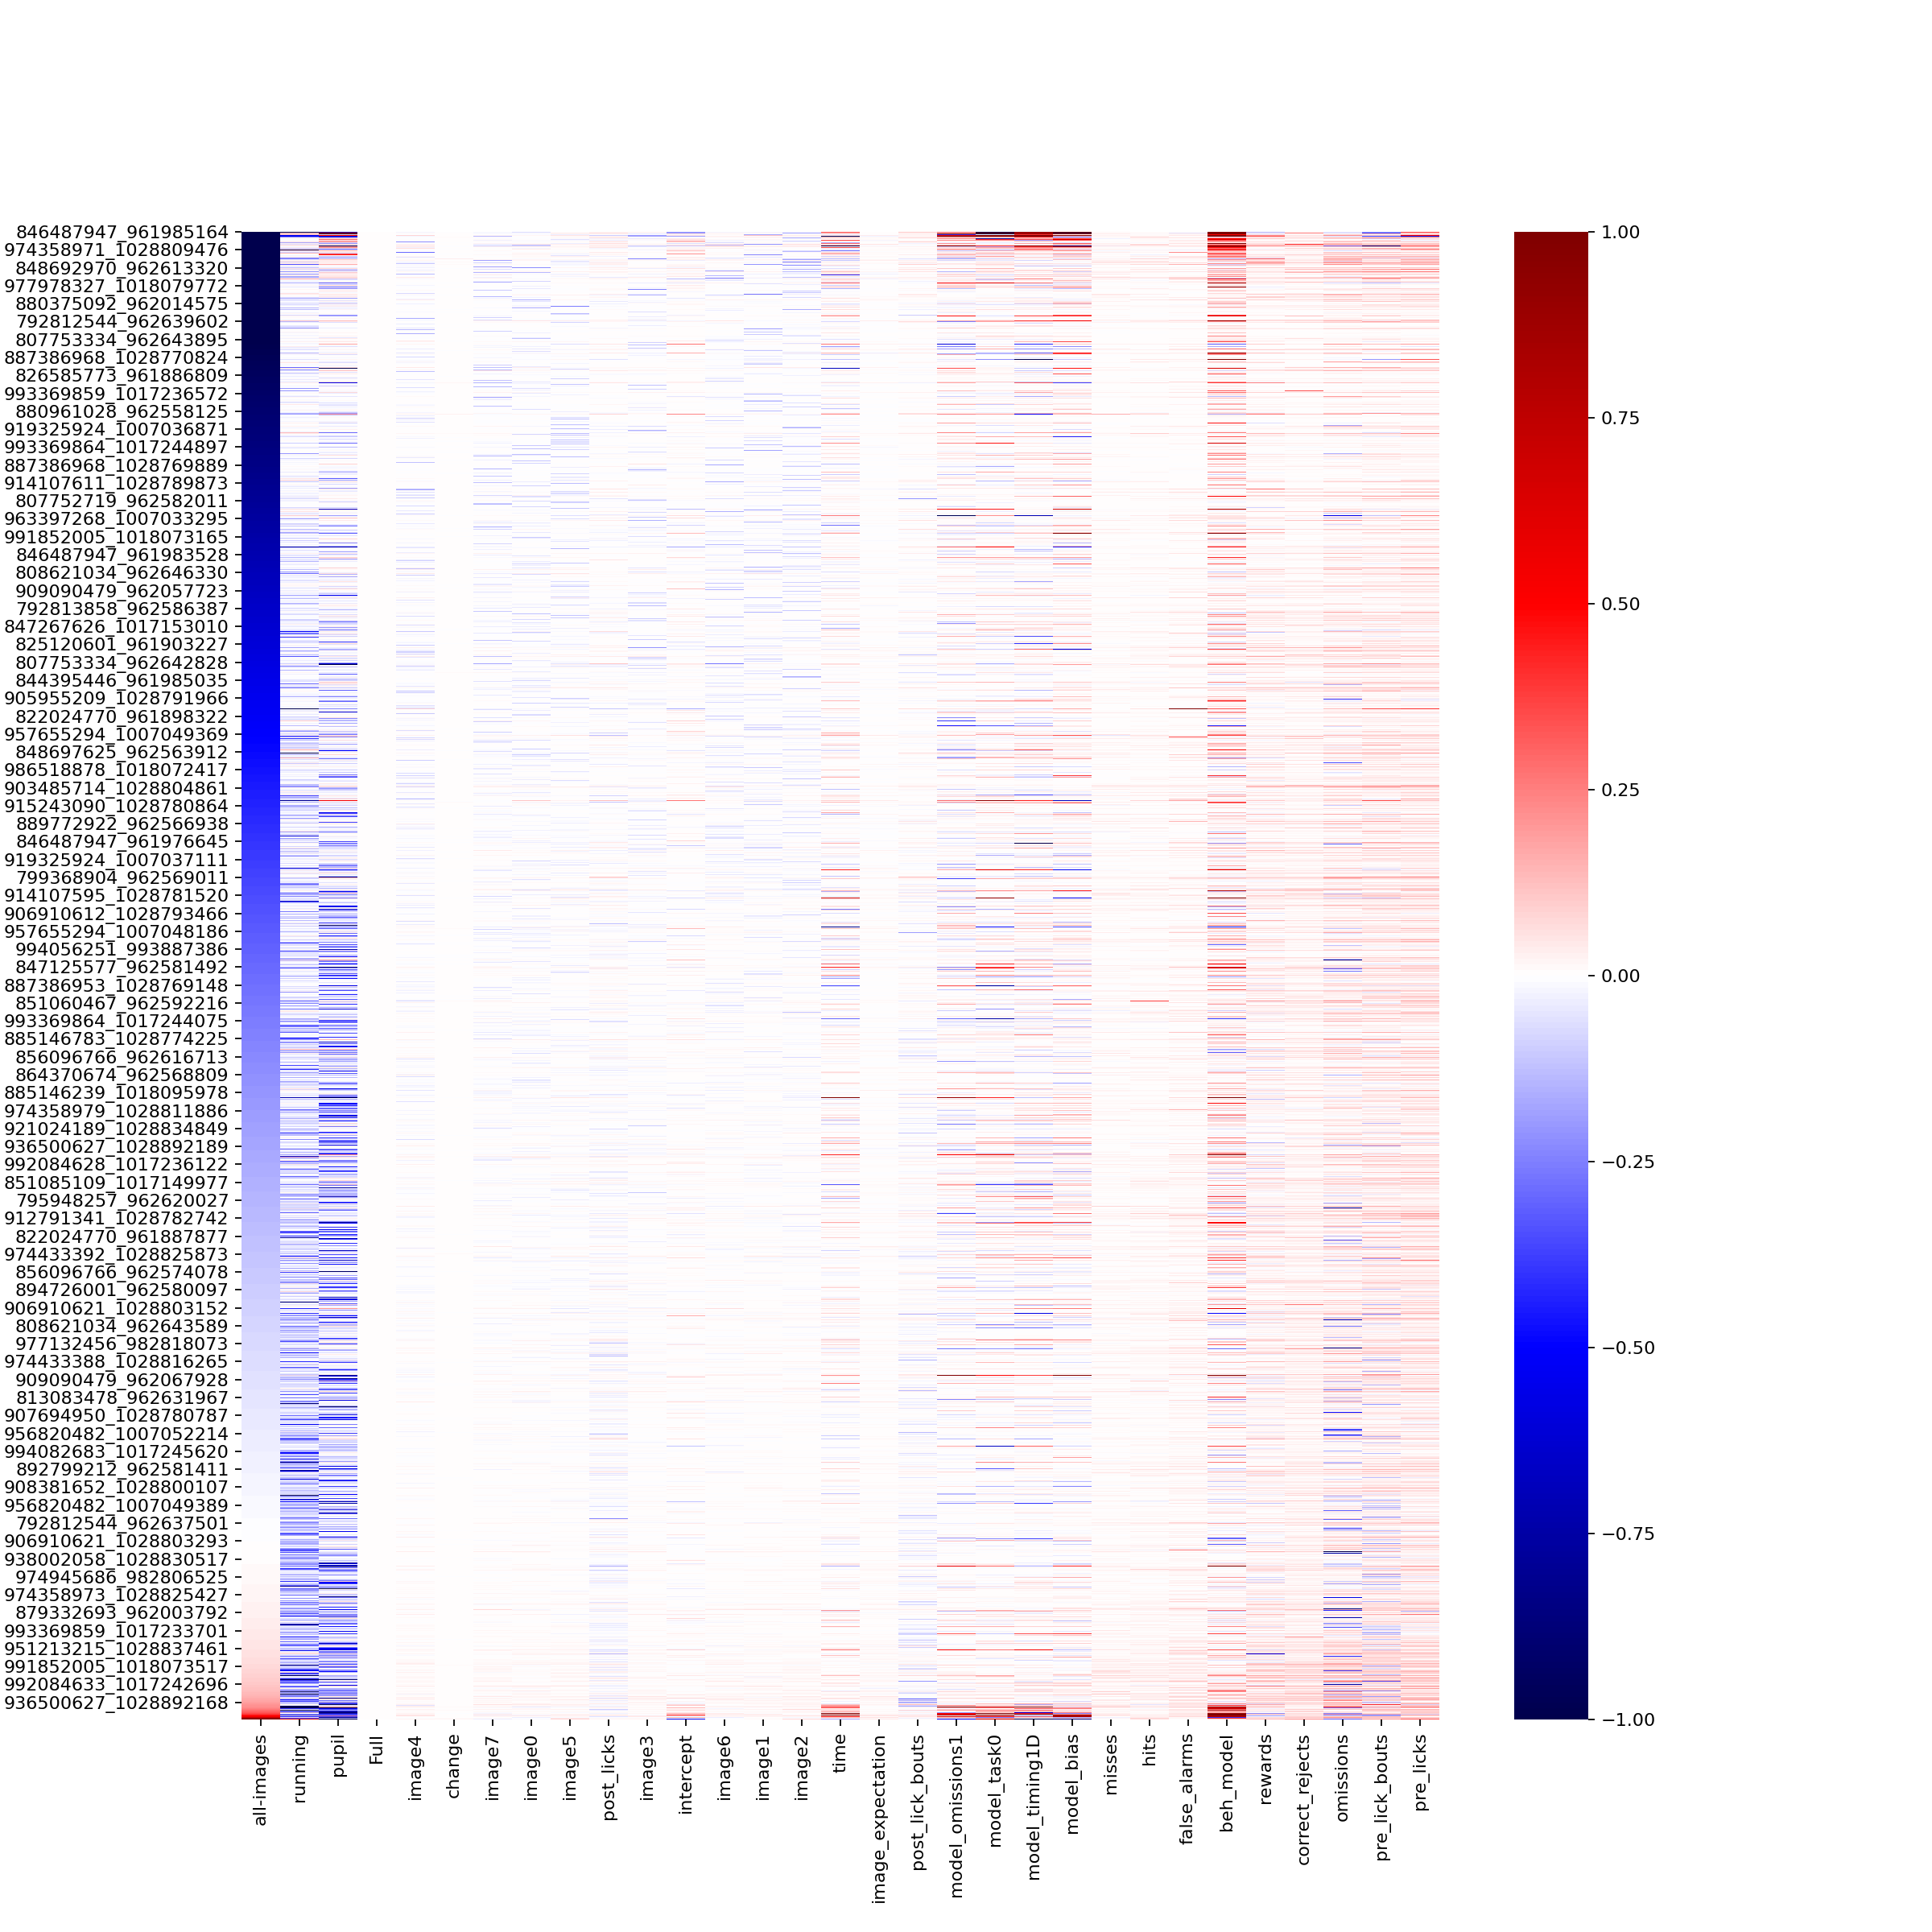

In [14]:
fig,ax=plt.subplots(figsize=(15,15))
sns.heatmap(
    rspm.set_index('identifier')[sorted_cols].sort_values(by=['all-images']),
    ax=ax,
    vmin=-1,
    vmax=1,
    cmap='seismic'
)

In [15]:
from sklearn.cluster import DBSCAN

In [190]:
len(cols_for_clustering)

31

In [16]:
clustering = DBSCAN(eps=10, min_samples=400).fit(rspm.set_index('identifier')[cols_for_clustering])

In [17]:
np.unique(clustering.labels_)

array([0])

In [18]:
rspm['db_scan_label'] = clustering.labels_

In [19]:
rspm['db_scan_label'].value_counts()

0    26795
Name: db_scan_label, dtype: int64

In [20]:
import umap

reducer_2d = umap.UMAP(n_components=2)
reducer_3d = umap.UMAP(n_components=3)

embedding_2d = reducer_2d.fit_transform(rspm[cols_for_clustering])
embedding_3d = reducer_3d.fit_transform(rspm[cols_for_clustering])
embedding_3d.shape

/home/dougo/.conda/envs/visual_behavior/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


(26795, 3)

In [21]:
rspm['umap_3d_embedding_0'] = embedding_3d[:, 0]
rspm['umap_3d_embedding_1'] = embedding_3d[:, 1]
rspm['umap_3d_embedding_2'] = embedding_3d[:, 2]

rspm['umap_2d_embedding_0'] = embedding_2d[:, 0]
rspm['umap_2d_embedding_1'] = embedding_2d[:, 1]

In [22]:
clustering = DBSCAN(eps=0.5, min_samples=10).fit(rspm.set_index('identifier')[['umap_3d_embedding_0','umap_3d_embedding_1','umap_3d_embedding_2']])

In [23]:
rspm['db_scan_label'] = clustering.labels_
rspm['db_scan_label'].value_counts()

 0    26793
-1        2
Name: db_scan_label, dtype: int64

In [84]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15)
umap_cols = ['umap_3d_embedding_0','umap_3d_embedding_1','umap_3d_embedding_2']
rspm['k_means_on_3d_umap'] = kmeans.fit_predict(rspm[umap_cols])
rspm['k_means_on_3d_umap'].value_counts()

9     2667
12    2493
8     2436
7     2398
2     2361
4     1999
3     1789
14    1591
1     1577
10    1549
13    1445
6     1367
5     1341
0     1055
11     727
Name: k_means_on_3d_umap, dtype: int64

<IPython.core.display.Javascript object>


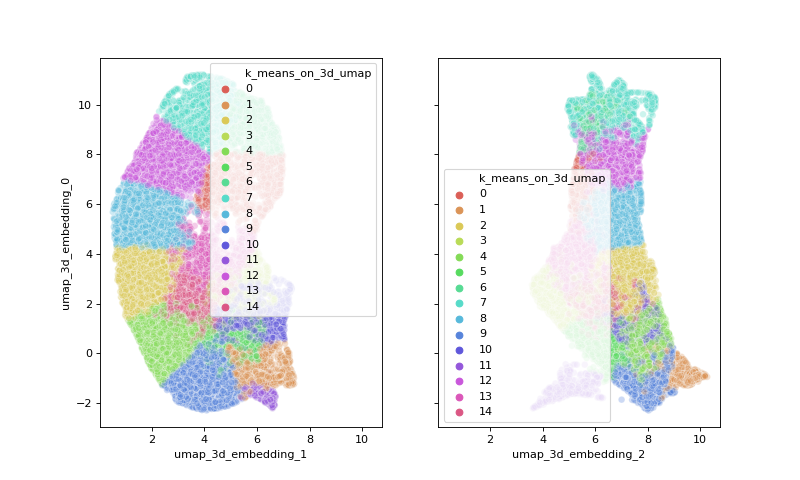

In [86]:
fig,ax=plt.subplots(1,2,figsize=(10,6),sharey=True,sharex=True)
sns.scatterplot(
    x='umap_3d_embedding_1', 
    y='umap_3d_embedding_0',
    hue='k_means_on_3d_umap',
    palette=sns.color_palette("hls", len(rspm['k_means_on_3d_umap'].unique())),
    data=rspm,
    legend='full',
    alpha=0.3,
    ax=ax[0],
)
sns.scatterplot(
    x='umap_3d_embedding_2', 
    y='umap_3d_embedding_0',
    hue='k_means_on_3d_umap',
    palette=sns.color_palette("hls", len(rspm['k_means_on_3d_umap'].unique())),
    data=rspm,
    legend='full',
    alpha=0.3,
    ax=ax[1],
)

In [187]:
import plotly.express as px
fig = px.scatter_3d(
    rspm, 
    x='umap_3d_embedding_0', 
    y='umap_3d_embedding_1', 
    z='umap_3d_embedding_2',
    color='k_means_on_3d_umap'
)
fig.update_layout(
    margin=dict(l=30, r=30, t=10, b=10),
    width=1200,
    height=1000,
)
fig.write_html("/home/dougo/code/dougollerenshaw.github.io/figures_to_share/2020.08.18_k_means_on_umap.html")
fig.show()

In [126]:

data

index  k_means_on_3d_umap  umap_3d_embedding_0  umap_3d_embedding_1  \
0       2858                   0             4.847966             5.845397   
1        460                   0             4.848095             5.857584   
2       1863                   0             4.852028             5.846295   
3      20162                   0             4.870772             5.858002   
4       2642                   0             4.895032             5.884089   
...      ...                 ...                  ...                  ...   
26790  14174                  14             3.338926             3.469960   
26791  18387                  14             3.375496             3.356925   
26792  14659                  14             3.404623             3.446049   
26793  18416                  14             3.405260             3.300663   
26794   6477                  14             3.423691             3.118608   

       umap_3d_embedding_2  all-images   running     pupil  Full    image4  \
0                 5.392168   -0.242515 -0.216781 -0.345101   0.0 -0.040082   
1                 5.370636   -0.140054 -0.151192 -0.392879   0.0  0.025578   
2                 5.414773    0.001831 -0.103022 -0.098591   0.0 -0.030410   
3                 5.356886    0.225444 -1.682256  0.180318   0.0  0.031489   
4                 5.199645   -0.311295 -0.082267  0.031999   0.0 -0.117869   
...                    ...         ...       ...       ...   ...       ...   
26790             7.495464   -0.348111 -0.306323 -0.027162   0.0 -0.052225   
26791             6.713976   -0.396042 -0.255075 -0.178936   0.0  0.001719   
26792             6.537127   -0.345137 -0.013709  0.038384   0.0  0.005911   
26793             6.881529   -0.375395 -0.258897 -0.150369   0.0 -0.018650   
26794             6.480584   -0.352611 -0.176790 -0.150563   0.0 -0.004186   

         change    image7    image0    image5  post_licks    image3  \
0      0.001129 -0.015428 -0.006948 -0.030055   -0.024045  0.025844   
1      0.003817  0.020738  0.016758  0.012340    0.040535  0.006158   
2      0.003747  0.022980  0.051915  0.040387    0.032403  0.016172   
3      0.009045  0.022052 -0.039533 -0.022757    0.023048  0.014726   
4      0.001941 -0.086863 -0.024894  0.017022   -0.012830 -0.017324   
...         ...       ...       ...       ...         ...       ...   
26790  0.003007 -0.026099  0.018028  0.006869   -0.060977  0.010631   
26791  0.002504  0.001493  0.001389  0.001146    0.000239  0.001031   
26792  0.001540 -0.024968 -0.001243  0.001664    0.004994 -0.078478   
26793  0.001873  0.001858 -0.022264 -0.012097   -0.027419 -0.015642   
26794  0.000157 -0.008795 -0.002374 -0.000184   -0.000389 -0.000794   

       intercept    image6    image1    image2      time  image_expectation  \
0       0.022035  0.038090  0.024594  0.042251  0.226506           0.014896   
1      -0.033425  0.006440  0.004113  0.004352 -0.093743          -0.012897   
2       0.063354  0.000364  0.005383 -0.003858  0.104551           0.023783   
3       0.019237  0.029542  0.036196  0.019855  0.467387          -0.002899   
4       0.222681 -0.023479 -0.017095 -0.009603  0.313219           0.010887   
...          ...       ...       ...       ...       ...                ...   
26790   0.001478  0.017355  0.023262  0.028850  0.003940           0.017957   
26791  -0.019207  0.002391 -0.004672  0.002767 -0.023421           0.001480   
26792   0.012636 -0.001344 -0.042528  0.009910 -0.000518           0.012418   
26793   0.002856  0.014849  0.013330 -0.004204 -0.016367           0.004999   
26794   0.000883  0.000766  0.003378 -0.001550 -0.001061          -0.002585   

       post_lick_bouts  model_omissions1  model_task0  model_timing1D  \
0             0.023940          0.153163     0.177324        0.689247   
1            -0.016865          0.270470     0.198176        0.677093   
2             0.028948          0.309011     0.121639        1.099990   
3             0.023217          1.84446

In [127]:
cluster_column_name = 'k_means_on_3d_umap'
for cluster_id in data[cluster_column_name].unique():
    data_subset = data.query("{} == {}".format(cluster_column_name, cluster_id))
    
    data.loc[data_subset.index,'dominant_dropout']=data_subset[cols_for_clustering].median(axis=0).idxmin()
    data.loc[data_subset.index,'dominant_dropout_median']=data_subset[cols_for_clustering].median(axis=0).min()

In [128]:
(data
 .sort_values(by=['dominant_dropout_median','k_means_on_3d_umap','umap_3d_embedding_0','umap_3d_embedding_1','umap_3d_embedding_2'])
 .drop(columns=['index','k_means_on_3d_umap','dominant_dropout_median','dominant_dropout']+umap_axes)
 .reset_index(drop=True)
)

all-images   running     pupil  Full    image4    change    image7  \
0       -1.581678  0.022226  0.051513   0.0 -0.004816  0.000514  0.002154   
1       -1.705370  0.040767  0.001522   0.0  0.009024  0.001047 -0.006646   
2       -1.672846  0.008097 -0.009666   0.0  0.005028  0.000132  0.000134   
3       -1.674482  0.071494  0.017378   0.0  0.011975  0.000501  0.004243   
4       -1.360700  0.397874  0.265998   0.0  0.000752  0.005455  0.009146   
...           ...       ...       ...   ...       ...       ...       ...   
26790   -0.125709 -0.162849 -0.038110   0.0 -0.002902  0.000793  0.009882   
26791   -0.139237 -0.177865  0.060817   0.0 -0.000502  0.001566  0.003138   
26792   -0.112195 -0.196050  0.043512   0.0 -0.044461  0.000496  0.030328   
26793   -0.120034 -0.189944  0.039261   0.0 -0.046865  0.004974 -0.003833   
26794   -0.127571 -0.186574  0.014819   0.0 -0.033034  0.001040  0.024442   

         image0    image5  post_licks    image3  intercept    image6  \
0     -0.030959  0.005059    0.011516  0.003472   0.005885  0.005269   
1      0.001227  0.019471   -0.034107  0.005872  -0.002245  0.010532   
2      0.000166  0.000750    0.005626 -0.005253   0.013910 -0.002711   
3      0.006059  0.015467   -0.003816  0.012561  -0.003951 -0.133059   
4     -0.016518  0.006858    0.008477 -0.006213  -0.084922  0.001915   
...         ...       ...         ...       ...        ...       ...   
26790  0.002520  0.002010    0.010807 -0.001458   0.001457  0.014344   
26791  0.008460  0.003140    0.016919 -0.015090   0.004592  0.002229   
26792  0.018750 -0.001755    0.029644  0.035246   0.000629  0.024307   
26793  0.001725 -0.004833    0.011593  0.015696   0.006326  0.010279   
26794  0.006206 -0.005852   -0.028183  0.020717  -0.018430 -0.032171   

         image1    image2      time  image_expectation  post_lick_bouts  \
0      0.001641  0.005396 -0.031670           0.001146         0.001026   
1     -0.229642 -0.013301  0.038426          -0.006015         0.030657   
2     -0.000053 -0.001254  0.005118          -0.000150         0.001839   
3     -0.066204  0.005857  0.072890           0.013234         0.014086   
4      0.008197  0.005949 -0.193266           0.007092        -0.015890   
...         ...       ...       ...                ...              ...   
26790  0.000957  0.017865  0.002635           0.001245         0.018163   
26791  0.004801 -0.004496  0.022029           0.003952         0.019665   
26792  0.005465  0.012134 -0.022094           0.002540         0.025769   
26793  0.018190 -0.015421 -0.007779           0.016858         0.004211   
26794  0.008079  0.021727  0.000586          -0.002167         0.001985   

       model_omissions1  model_task0  model_timing1D  model_bias    misses  \
0              0.041696    -0.041047        0.109012    0.091164  0.000708   
1              0.006651    -0.032276        0.074186    0.057351  0.029708   
2             -0.006005    -0.014528       -0.090267    0.020153  0.000196   
3              0.007324     0.008592       -0.068849    0.021565 -0.038853   
4              0.084992    -0.457470       -0.032191    0.330910  0.040652   
...                 ...          ...             ...         ...       ...   
26790          0.017132    -0.002020        0.013052   -0.007600  0.018625   
26791         -0.007585    -0.012645       -0.036834    0.002900  0.004990   
26792         -0.008749    -0.000713       -0.004094    0.004543  0.033145   
26793          0.006476    -0.006844        0.002197   -0.004680  0.028655   
26794          0.006604     0.008084        0.000130    0.003231  0.006679   

           hits  false_alarms  beh_model   rewards  correct_rejects  \
0      0.003098      0.009163   0.150697  0.021507         0.004294   
1     -0.005560     -0.032192   0.080480 -0.014020         0.064277   
2     -0.000356      0.000967  -0.078353  0.008049         0.000860   
3      0.011608      0.015810   0.079077  0.035014         0.066532   
4      0.031347      0.0

In [154]:
cols_by_effect_size = list(data[cols_for_clustering].abs().median(axis=0).sort_values(ascending=False).index)
cols_by_effect_size

['all-images',
 'pupil',
 'running',
 'pre_lick_bouts',
 'pre_licks',
 'omissions',
 'beh_model',
 'rewards',
 'correct_rejects',
 'model_bias',
 'model_timing1D',
 'false_alarms',
 'hits',
 'model_task0',
 'post_lick_bouts',
 'model_omissions1',
 'post_licks',
 'misses',
 'time',
 'image2',
 'image7',
 'image6',
 'image3',
 'image4',
 'image0',
 'image5',
 'image1',
 'image_expectation',
 'intercept',
 'change',
 'Full']

<IPython.core.display.Javascript object>


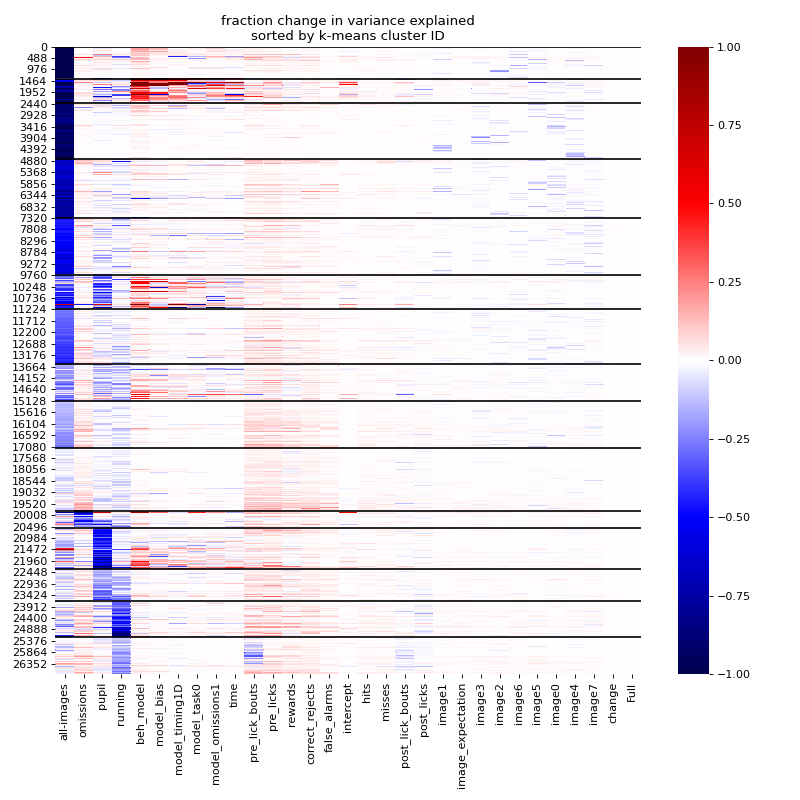

In [186]:
fig,ax=plt.subplots(figsize=(10,10))

data = rspm[['k_means_on_3d_umap'] + umap_axes + list(cols_for_clustering)].sort_values(by=['k_means_on_3d_umap','umap_3d_embedding_0','umap_3d_embedding_1','umap_3d_embedding_2']).reset_index()
cluster_column_name = 'k_means_on_3d_umap'
for cluster_id in data[cluster_column_name].unique():
    data_subset = data.query("{} == {}".format(cluster_column_name, cluster_id))
    
    data.loc[data_subset.index,'dominant_dropout']=data_subset[cols_for_clustering].median(axis=0).idxmin()
    data.loc[data_subset.index,'dominant_dropout_median']=data_subset[cols_for_clustering].median(axis=0).min()
    

umap_axes = ['umap_3d_embedding_0','umap_3d_embedding_1','umap_3d_embedding_2']
data_to_plot = (data
     .sort_values(by=['dominant_dropout','dominant_dropout_median','k_means_on_3d_umap','umap_3d_embedding_0','umap_3d_embedding_1','umap_3d_embedding_2'])
     .reset_index(drop=True)
    )

data_to_plot['cluster_transition'] = data_to_plot['k_means_on_3d_umap'] != data_to_plot['k_means_on_3d_umap'].shift()
for idx,row in data_to_plot.query('cluster_transition').iterrows():
    ax.axhline(idx,color='black')

sorted_cols = list(data_to_plot.query('cluster_transition')['dominant_dropout'].unique())
# cols_by_effect_size = list(data[cols_for_clustering].median(axis=0).abs().sort_values(ascending=False).index)
cols_by_effect_size = list(data[cols_for_clustering].quantile(0.99).abs().sort_values(ascending=False).index)

sorted_cols += [col for col in cols_by_effect_size if col not in sorted_cols]

sns.heatmap(
    data_to_plot.drop(columns=['index','k_means_on_3d_umap','dominant_dropout_median','dominant_dropout','cluster_transition']+umap_axes)[sorted_cols],
    ax=ax,
    vmin=-1,
    vmax=1,
    cmap='seismic'
)
ax.set_title('fraction change in variance explained\nsorted by k-means cluster ID')
fig.tight_layout()